In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

In [2]:
sys.path.append("/home/rzhu/Documents/nwn_l2l/")

In [3]:
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

In [4]:
con = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/con0.pkl")
# con = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/con_100_261.pkl")
adj = torch.tensor(con["adj_matrix"])
net     = NWN(adj, "sydney")
distMat = graphical_distance(net.adjMat)

R,C = np.where(distMat == distMat.max())

In [5]:
# net                     = NWN(adj, "sydney")
# E                       = net.number_of_junctions
# net.params["Ron"]       = 1e4
# net.params["grow"]      = 5
# net.params["decay"]     = 10
# net.params["precision"] = True
# net.params["collapse"]  = False
# net.params["dt"]        = 1e-3

# # net.params["Vset"]      = 0.01
# # net.params["Vreset"]    = 0.01

# T0         = 1500
# # electrodes = torch.tensor([R[0], C[1]])
# electrodes = torch.tensor([27,26])
# netG       = torch.zeros(10000)

# for t in tqdm(range(T0)):
#     sig_in = torch.zeros(len(electrodes))
#     sig_in[0] = 1

#     net.sim(sig_in.reshape(1,-1), electrodes)
#     netG[t] = net.I[1] / sig_in[0]

In [6]:
# onAmp            = 2
# b                = 1
# Tmax             = 3
# n_out            = 1000
# steps            = int(Tmax / 1e-3)
# net.params["dt"] = 1e-2

# torch.manual_seed(0)
# elec_out = torch.randint(low = 0, high = 100, size = (1,n_out))
# readout  = torch.zeros(steps, n_out)
# netG2    = torch.zeros(steps)
# sig      = torch.rand(steps) * 2 - 1
# tvec     = torch.arange(0,Tmax, 1e-3)
# # sig      = torch.sin(2*torch.pi*tvec)

# for t in tqdm(range(steps)):
#     sig_in = torch.zeros(len(electrodes))
#     sig_in[0] = sig[t] * onAmp + b

#     net.sim(sig_in.reshape(1,-1), electrodes)
#     readout[t,:] = net.V[elec_out]
#     netG2[t]     = net.I[1] / sig_in[0]

In [7]:
data = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/pair_0.pkl")
X,Y = data

In [98]:
net                     = NWN(adj, "sydney")
E                       = net.number_of_junctions
net.params["Ron"]       = 1e4
net.params["grow"]      = 5
net.params["decay"]     = 10
net.params["precision"] = True
net.params["collapse"]  = False
net.params["dt"]        = 1e-3
net.junction_state.L    = torch.rand(E) * 0.3 - 0.15

In [99]:
# onAmp = 2
# b     = 1
Tmax  = 3
steps = int(Tmax / 1e-3)


# torch.manual_seed(0)
netG2    = torch.zeros(steps)
tvec     = torch.arange(0,Tmax, 1e-3)
# sig      = torch.sin(2*torch.pi*tvec)

n_input    = 200
n_out      = 200
electrodes = torch.randperm(1024)[:n_input+1]
elec_out   = torch.randperm(1024)[-n_out:]
W_in       = torch.rand(n_input, 1)
sig        = torch.rand(steps) * 2 - 1
# sig        = X

readout  = torch.zeros(steps, n_out)

for t in tqdm(range(steps)):
    # sig_in = torch.zeros(len(electrodes))
    # sig_in[0] = sig[t] * onAmp + b

    sig_in = torch.zeros(n_input + 1)
    sig_in[:-1] = W_in @ sig[[0]]

    net.sim(sig_in.reshape(1,-1), electrodes)
    readout[t,:] = net.V[elec_out]
    netG2[t]     = net.I[1] / sig_in[0]

100%|██████████| 3000/3000 [00:32<00:00, 91.03it/s]


In [100]:
def calc_MC(readout, target, 
            tau = 1, T0 = 0, L = 1000):
    pick        = torch.arange(T0,T0+L)
    readout_tau = readout[pick+tau]
    target_tau  = target[pick]
    weight, result, rcond = best_regress(readout_tau, target_tau)

    predict = weight @ readout_tau.T
    # mc      = torch.cov(torch.vstack((predict, target_tau)))[0,1]**2 / \
    #     (torch.var(predict) * torch.var(target_tau))
    mc      = torch.cov(torch.vstack((predict, target_tau)))[0,1]**2 / \
                (torch.var(predict) * torch.var(target[pick+tau]))
    # mc = torch.corrcoef(torch.stack((predict, target_tau)))[0,1]**2

    return mc

In [101]:
MC = torch.zeros(100)
for i in tqdm(range(1,101)):
    MC[i-1] = calc_MC(readout, sig, i, 500, 1000)

100%|██████████| 100/100 [00:03<00:00, 32.61it/s]


tensor(0.6452)


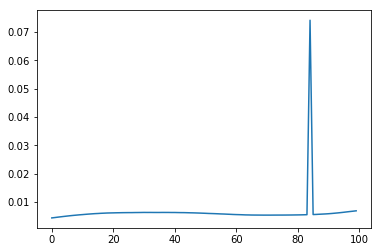

In [102]:
plt.plot(MC)
print(MC.sum())